In [98]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from scipy.io import loadmat,savemat
from avalanche_parse import avalanche_parse as avparse
from os import system

In [57]:
# Weight matrix generation function
# mode = 0  k-1-param1-k-param1-k+1   k-2-param2-k-param2-k+2
# mode = 1  SmallWorld param1 = K param2 = rewire param3 = w
def generate_matrix(mode,N,param1,param2,param3,wfilename):
    mat = np.zeros((N,N))
    if mode==0:
        for i in range(N):
            for j in range(N):
                if abs(i-j)==1:
                    mat[i][j]=param1
                elif abs(i-j)==2:
                    mat[i][j]=param2
    elif mode == 1:
        mat = nx.to_numpy_array(nx.watts_strogatz_graph(N,param1,param2))*param3
        print(N,param1,param2,param3)
    elif mode == 2:
        mat = nx.to_numpy_array(nx.watts_strogatz_graph(N,param1,param2))*np.random.normal(0.0,0.3,size=(N,N))
    np.savetxt("Weights/{}.txt".format(wfilename),mat,fmt='%.3f')
    
# Raster Loading and splitting
def load_raster(N,filename):
    raster = np.zeros((N,100000))
    with open("Rasters/{}.txt".format(filename)) as O:
        lc = 0
        for line in O:
            raster[lc,list(map(int,line.strip().split()))]=1
            lc+=1
    return raster

def save_matlab(N,M,infilename,outfilename):
    raster = load_raster(N,infilename)
    subraster = raster[np.random.choice(range(N),M,replace=False),:]
    plt.figure(figsize=(25,3)) #plot
    plt.imshow(subraster,aspect="auto")
    plt.show()
    savemat("MatlabRasters/{}.mat".format(outfilename),{"binnedSpikes":subraster})
    print("Ajustar('MatlabRasters','MaxEntParams','{}.mat');".format(outfilename))


def run_matlab(filename,back=0):
    system("""matlab -nodisplay -nosplash -nodesktop -r "cd('MaxEntCode');Ajustar('../MatlabRasters','../MaxEntParams','{}.mat');exit()" """.format(filename)+["","&"][back])
    
def load_params(N,infilename):
    ising = loadmat("MaxEntParams/{}.mat".format(infilename))
    params = ising["params"] # N , N*(N-1)/2
    J = np.zeros((N,N)) #FullMatrix for indexing
    J[np.triu_indices(N, 1)] = params[:,0][N:] #UpperTri Matrix
    H = params[:,0][:N] #<h,sigma>
    return H,J
    
    

25 4 0.2 0.2


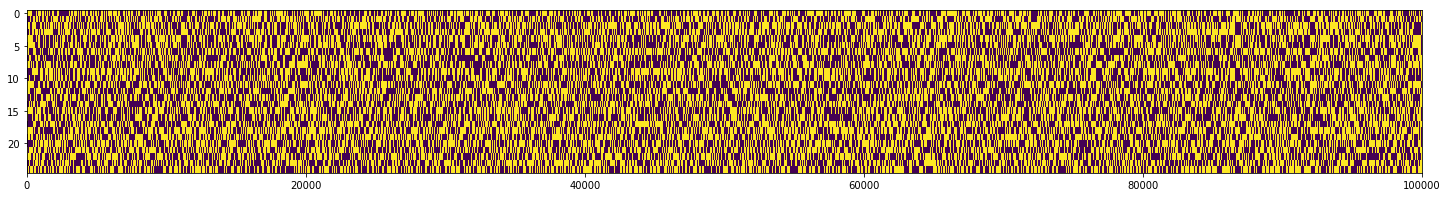

Ajustar('MatlabRasters','MaxEntParams','nuevo2.mat');


In [ ]:
# Testing
def run_everything(wfilename,outfilename):
    generate_matrix(1,25,4,0.2,0.2,wfilename) #generate weight matrix
    system("./BMS 25 Weights/{}.txt Rasters/{}.txt".format(wfilename,outfilename)) #generates raster from weight matrix to outfilename
    ras=load_raster(25,outfilename) #loads raster from outfilename
    plt.figure(figsize=(25,3)) #plot
    plt.imshow(ras,aspect="auto")
    plt.show()
    save_matlab(25,20,outfilename,outfilename) #creates a sub-raster matlab file
    run_matlab(outfilename) #runs matlab maxent over the subraster
    h,j = load_params(20,outfilename) #gets maxent params from the subraster model
    print (h)
    print (j)
run_everything("matriz1","nuevo2")

In [ ]:
# Standard Workflow
wfilename = "smallworldrw"
rastername = "N100SW"
N = 100
generate_matrix(1,N,4,0.4,0.2,wfilename)
system("./BMS {} Weights/{}.txt Rasters/{}.txt".format(N,wfilename,rastername))
params = []
for n in [20,40]:
    subrastername = rastername+"x{}".format(n)
    save_matlab(N,n,rastername,subrastername)
    run_matlab(subrastername,1)
    params.append(load_params(n,subrastername))

In [ ]:
# Another workflow
wfilename = "smallworldrw"
rastername = "N100SW"
N = 160
filenames = [("160SWk4r.4wN.3","160SWk4r.5wN.3")]
generate_matrix(2,N,4,0.4,0.2,"160SWk4r.4wN.3")
generate_matrix(2,N,4,0.5,0.2,"160SWk4r.5wN.3")

for rastername in ["160SWk4r.4wN.3","160SWk4r.5wN.3"]:
    system("./BMS {} Weights/{}.txt Rasters/{}.txt".format(N,rastername,rastername))
    params = []
    for n in [20,40,60,80,100,120,140,160]:
        for s in range(5):
            print(rastername,n)
            subrastername = rastername+"sub{}samp{}".format(n,s)
            save_matlab(N,n,rastername,subrastername)
            run_matlab(subrastername,1)
            if n==160:
                break #single sample
            #params.append(load_params(n,subrastername))

## Notes

Run time of N=80 ~ 30min

In [94]:
#pipeline: smallword custom, pesos gaussianos, 
def saveForSH():
    for rastername in ["160SWk4r.4wN.3","160SWk4r.5wN.3"]:
        for n in [20,40,60,80,100,120,140,160]:
            for samp in range(5):
                subrastername = rastername+"sub{}samp{}".format(n,samp)
                h,j = load_params(n,subrastername)
                np.savetxt("SHParams/{}H.txt".format(subrastername),h)
                np.savetxt("SHParams/{}J.txt".format(subrastername),j)
                if n==160:
                    break

saveForSH()

notnull: 150


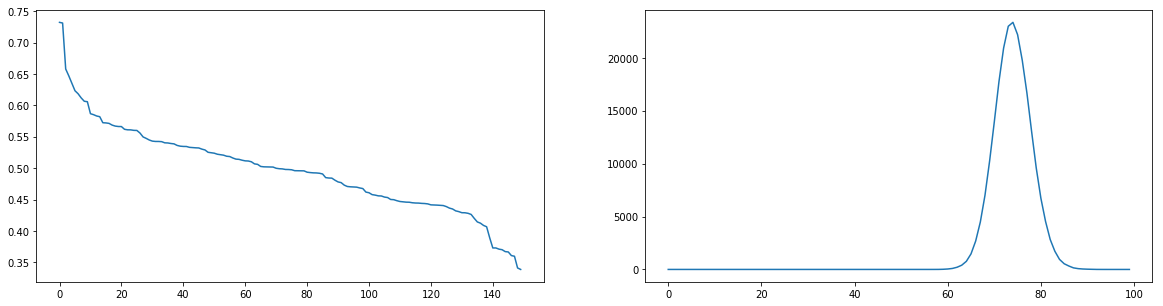

notnull: 150


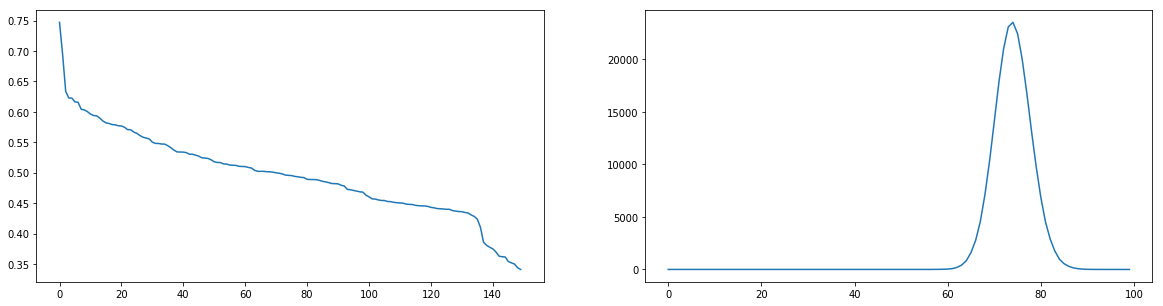

In [124]:
R = load_raster(150,"w150SWk4r.5w.2")
print("notnull:",sum(R.any(axis=1)))
spr = np.sum(R,axis=1)/100000
avc = [len(avparse(R.T,n)[0]) for n in range(100) ]
plt.figure(figsize=(20,5))
plt.subplot(121)
plt.plot(range(150),sorted(spr)[::-1])
plt.subplot(122)
plt.plot(range(100),avc)
plt.show()
R = load_raster(150,"w150SWk4r.4w.2")
print("notnull:",sum(R.any(axis=1)))
spr = np.sum(R,axis=1)/100000
avc = [len(avparse(R.T,n)[0]) for n in range(100) ]
plt.figure(figsize=(20,5))
plt.subplot(121)
plt.plot(range(150),sorted(spr)[::-1])
plt.subplot(122)
plt.plot(range(100),avc)
plt.show()

In [127]:
params = []
for rastername in ["160SWk4r.4wN.3","160SWk4r.5wN.3"]:
    for n in [20,40,60,80,100]:
        for s in range(5):
            subrastername = rastername+"sub{}samp{}".format(n,s)
            params.append(load_params(n,subrastername))
            h,j = load_params(n,subrastername)
            if np.array_equal(j,np.zeros((n,n))):
                print("ZEROJ",subrastername)
            if n==160:
                break #single sample


In [53]:
np.array_equal(params[15][1],np.zeros(80))

False

array([3., 3.])